In [1]:
# cfg_flow_celltype.py
# Full script: classifier-free guidance trained on cell type
import os
from typing import Optional
import math
import anndata as ad
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
from tqdm import tqdm
!nvidia-smi


/bin/bash: line 1: nvidia-smi: command not found


In [2]:
# ---- device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ---- paths (edit if needed)
input_file_path = "/dtu/blackhole/06/213542/paperdata/pbmc3k_train_with_latent.h5ad"
flow_model_save_path = "/dtu/blackhole/06/213542/paperdata/simple_flow_model_state.pth"
generated_save_path = "/dtu/blackhole/06/213542/paperdata/simple_generated_latent.pt"
os.makedirs(os.path.dirname(flow_model_save_path), exist_ok=True)
os.makedirs(os.path.dirname(generated_save_path), exist_ok=True)

In [3]:
# ---- load data
adata = ad.read_h5ad(input_file_path)
latent = adata.obsm["X_latent"]
latent_tensor = torch.tensor(latent, dtype=torch.float32, device=device)
print("Shape of latent space:", latent.shape)

# ---- NEW: Compute Library Sizes (Total Counts)
# We calculate total counts, log-transform them, and get stats for normalization
# Note: Ensure adata.X contains raw counts or use adata.obs['total_counts'] if available
if "total_counts" in adata.obs:
    lib_sizes = adata.obs["total_counts"].values
else:
    # Sum counts across genes for each cell
    lib_sizes = np.array(adata.X.sum(1)).flatten()

# Log transform (add 1 for stability)
log_lib_sizes = np.log(lib_sizes + 1)
log_lib_tensor = torch.tensor(log_lib_sizes, dtype=torch.float32, device=device).unsqueeze(1)

# Calculate stats for normalization (min/max) and sampling (mean/std)
lib_min = log_lib_tensor.min()
lib_max = log_lib_tensor.max()
lib_mean = log_lib_tensor.mean()
lib_std = log_lib_tensor.std()

print(f"Library Size Stats (Log): Min={lib_min:.2f}, Max={lib_max:.2f}, Mean={lib_mean:.2f}, Std={lib_std:.2f}")

# ---- cell type labels
cell_types = adata.obs["cell_type"].astype(str).values
unique_types, inverse_idx = np.unique(cell_types, return_inverse=True)
num_cell_types = len(unique_types)
cell_type_idx = torch.tensor(inverse_idx, dtype=torch.long, device=device)

print(f"Found {num_cell_types} cell types: {unique_types}")

Shape of latent space: (2110, 50)
Library Size Stats (Log): Min=6.49, Max=7.86, Mean=7.42, Std=0.17
Found 8 cell types: ['B cells' 'CD14+ Monocytes' 'CD4 T cells' 'CD8 T cells' 'Dendritic cells'
 'FCGR3A+ Monocytes' 'Megakaryocytes' 'NK cells']


In [4]:
# ---- Empirical distribution (KDE-like sampler/log density)
class EmpiricalDistribution(torch.nn.Module):
    def __init__(self, data: torch.Tensor, bandwidth: Optional[float] = None, compute_log_density: bool = True):
        super().__init__()
        assert data.dim() == 2, "data must be shape (N, D)"
        data = data.contiguous()
        self.register_buffer("data", data)   # (N, D)
        self.n = data.shape[0]
        self.data_dim = data.shape[1]
        self.compute_log_density_flag = compute_log_density

        # bandwidth scalar
        if bandwidth is None:
            std = torch.std(data, dim=0).mean().item()
            factor = (4.0 / (self.data_dim + 2.0)) ** (1.0 / (self.data_dim + 4.0))
            bw = factor * (self.n ** (-1.0 / (self.data_dim + 4.0))) * (std + 1e-6)
            bw = float(bw)
        else:
            bw = float(bandwidth)
        self.register_buffer("bandwidth", torch.tensor(bw, device=self.data.device))
        # log constant as tensor
        self._log_const = -0.5 * self.data_dim * math.log(2.0 * math.pi) - self.data_dim * torch.log(self.bandwidth)

    @property
    def dim(self):
        return self.data_dim

    def sample(self, num_samples: int) -> torch.Tensor:
        idx = torch.randint(0, self.n, (num_samples,), device=self.data.device)
        return self.data[idx]

    def log_density(self, x: torch.Tensor) -> torch.Tensor:
        if not self.compute_log_density_flag:
            raise RuntimeError("log_density disabled (compute_log_density=False).")
        assert x.dim() == 2 and x.shape[1] == self.data_dim
        x = x.to(self.data.device)
        x_norm2 = (x ** 2).sum(dim=1, keepdim=True)             # (bs,1)
        data_norm2 = (self.data ** 2).sum(dim=1).unsqueeze(0)    # (1, N)
        cross = x @ self.data.t()                               # (bs, N)
        d2 = x_norm2 + data_norm2 - 2.0 * cross
        sigma2 = (self.bandwidth ** 2)
        exponents = -0.5 * d2 / (sigma2 + 1e-12)
        lse = torch.logsumexp(exponents, dim=1, keepdim=True)
        log_prob = math.log(1.0 / self.n) + lse + self._log_const
        return log_prob

In [5]:
emp_dist = EmpiricalDistribution(latent_tensor)


In [6]:
# ---- Gaussian conditional path / analytic vector field
class LinearAlpha():
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        return t
    def dt(self, t: torch.Tensor) -> torch.Tensor:
        return torch.ones_like(t)

class LinearBeta():
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        return 1 - t
    def dt(self, t: torch.Tensor) -> torch.Tensor:
        return -torch.ones_like(t)

class GaussianConditionalProbabilityPath():
    def __init__(self, p_data, alpha, beta):
        self.p_data = p_data
        self.alpha = alpha
        self.beta = beta

    def sample_conditioning_variable(self, num_samples: int) -> torch.Tensor:
        return self.p_data.sample(num_samples)

    def sample_conditional_path(self, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        # p_t(x|z) = N(alpha_t * z, beta_t^2 I)
        return self.alpha(t) * z + self.beta(t) * torch.randn_like(z)

    def conditional_vector_field(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        # u_t(x|z) as in your formula
        alpha_t = self.alpha(t)
        beta_t = self.beta(t)
        dt_alpha_t = self.alpha.dt(t)
        dt_beta_t = self.beta.dt(t)
        return (dt_alpha_t - dt_beta_t / beta_t * alpha_t) * z + (dt_beta_t / beta_t) * x

    def conditional_score(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        alpha_t = self.alpha(t)
        beta_t = self.beta(t)
        return (z * alpha_t - x) / beta_t ** 2

In [7]:

alpha = LinearAlpha()
beta = LinearBeta()
path = GaussianConditionalProbabilityPath(emp_dist, alpha, beta)

In [8]:
import torch
import torch.nn as nn
import math

# ---- Neural vector field components

# Helper for sinusoidal embeddings
def get_timestep_embedding(timesteps, embedding_dim, max_timescale=10000):
    assert timesteps.ndim == 1
    timesteps = timesteps * 1000.0
    half_dim = embedding_dim // 2
    emb = math.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, dtype=torch.float32, device=timesteps.device) * -emb)
    emb = timesteps[:, None] * emb[None, :]
    return torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)

class TimeEmbedder(nn.Module):
    def __init__(self, embed_dim=32, max_freq=1e4):
        super().__init__()
        assert embed_dim % 2 == 0
        self.embed_dim = embed_dim
        self.max_freq = max_freq
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.SiLU(),
            nn.Linear(embed_dim, embed_dim),
            nn.SiLU()
        )

    def forward(self, t):
        freqs = torch.exp(torch.linspace(0, math.log(self.max_freq), self.embed_dim // 2, device=t.device))
        args = t * freqs
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
        return self.mlp(emb)

class ResNetBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim),
            nn.SiLU(),
            nn.Linear(dim, dim)
        )
    def forward(self, x):
        return x + self.block(x)

class NeuralVectorField(nn.Module):
    def __init__(self, latent_dim, hidden_dim=256, n_resblocks=3, time_embed_dim=64, 
                 lib_min=None, lib_max=None): 
        super().__init__()
        self.x_proj = nn.Linear(latent_dim, hidden_dim)
        self.z_proj = nn.Linear(latent_dim, hidden_dim)
        
        # Library Size Projector
        self.lib_min = lib_min
        self.lib_max = lib_max
        self.l_proj = nn.Sequential(
            nn.Linear(time_embed_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

        self.time_embedder = TimeEmbedder(time_embed_dim)
        
        # Input dim: hidden + hidden + time_emb + library_emb (hidden)
        in_dim = hidden_dim * 3 + time_embed_dim 
        
        self.resblocks = nn.ModuleList([ResNetBlock(in_dim) for _ in range(n_resblocks)])
        self.output_layer = nn.Linear(in_dim, latent_dim)

    def forward(self, x, z, t, l):
        """
        x: (bs, latent_dim)
        z: (bs, latent_dim) -- conditioning
        t: (bs, 1)
        l: (bs, 1) -- log library size
        """
        xh = self.x_proj(x)
        zh = self.z_proj(z)
        th = self.time_embedder(t)
        
        # Process Library Size
        # 1. Normalize l to [0, 1]
        l_norm = (l - self.lib_min) / (self.lib_max - self.lib_min)
        l_norm = l_norm.squeeze()
        
        # 2. Sinusoidal Embedding
        l_emb_sin = get_timestep_embedding(l_norm, self.time_embedder.embed_dim)
        
        # 3. MLP Projection
        lh = self.l_proj(l_emb_sin)
        
        # Concatenate features
        h = torch.cat([xh, zh, th, lh], dim=-1)
        
        for block in self.resblocks:
            h = block(h)
        return self.output_layer(h)

In [9]:

# ---- cell-type conditioning module: one-hot projection + learned embedding
class CellTypeConditioner(nn.Module):
    def __init__(self, n_cell_types, latent_dim, use_one_hot=True, one_hot_proj_dim=None, embed_dim=None):
        super().__init__()
        self.n_types = n_cell_types
        self.latent_dim = latent_dim
        self.use_one_hot = use_one_hot
        # learned embedding
        embed_dim = latent_dim if embed_dim is None else embed_dim
        self.type_embed = nn.Embedding(n_cell_types, embed_dim)
        # project one-hot into same space if requested
        if self.use_one_hot:
            one_hot_proj_dim = latent_dim if one_hot_proj_dim is None else one_hot_proj_dim
            self.one_hot_proj = nn.Linear(n_cell_types, embed_dim)
        else:
            self.one_hot_proj = None
        # final projector to the latent_dim (z must be latent_dim)
        self.final_proj = nn.Linear(embed_dim, latent_dim)

    def forward(self, type_idx: torch.LongTensor):
        # type_idx: (bs,) long
        emb = self.type_embed(type_idx)   # (bs, embed_dim)
        if self.use_one_hot:
            # build one-hot
            bs = type_idx.shape[0]
            one_hot = torch.zeros(bs, self.n_types, device=type_idx.device)
            one_hot.scatter_(1, type_idx.unsqueeze(1), 1.0)
            oh_proj = self.one_hot_proj(one_hot)  # (bs, embed_dim)
            emb = emb + oh_proj
        z = self.final_proj(emb)  # (bs, latent_dim)
        return z

In [10]:


# ---- ODE wrapper and Euler simulator (stateless, accepts z)
class LearnedVectorFieldODE():
    def __init__(self, vf_model: nn.Module):
        self.vf_model = vf_model
    def drift_coefficient(self, x: torch.Tensor, t: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
        return self.vf_model(x, z, t)

class EulerSimulator():
    def __init__(self, ode: LearnedVectorFieldODE):
        self.ode = ode
    def step(self, xt: torch.Tensor, t: torch.Tensor, h: float, z: torch.Tensor):
        dx = self.ode.drift_coefficient(xt, t, z)
        return xt + dx * h

In [11]:

# ---- hyperparams
batch_size = 256
num_epochs = 2000
learning_rate = 1e-3
latent_dim = latent_tensor.shape[1]
drop_prob = 0.1   # classifier-free: drop conditioning p=0.1
guidance_scale = 2.0  # sampling: positive amplifies conditioning
n_steps = 50
dt = 1.0 / n_steps

In [13]:
vf_model = NeuralVectorField(latent_dim=latent_dim, hidden_dim=256, n_resblocks=3, time_embed_dim=64,
                             lib_min=lib_min, lib_max=lib_max).to(device)
cell_conditioner = CellTypeConditioner(n_cell_types=num_cell_types, latent_dim=latent_dim, use_one_hot=True).to(device)

optimizer = torch.optim.AdamW(list(vf_model.parameters()) + list(cell_conditioner.parameters()), lr=learning_rate)
# ---- training loop (Classifier-Free Guidance training on cell type)
# We'll train so that when we drop conditioning we feed z_null (zero vector) and sample x consistent with that null conditioning.
# ---- training loop
z_null = torch.zeros(1, latent_dim, device=device)

num_data = latent_tensor.shape[0]
dataset_indices = torch.arange(num_data, device=device)
cell_type_indices_per_data = cell_type_idx 

pbar = tqdm(range(num_epochs), desc="Training")

loss_list = []
epoch_list= []

for epoch in pbar:
    # sample dataset indices
    idx = torch.randint(0, num_data, (batch_size,), device=device)
    
    # get cell types and library sizes for this batch
    types = cell_type_indices_per_data[idx] 
    l_batch = log_lib_tensor[idx] # <--- CRITICAL: Extract library sizes for this batch
    
    drop_mask = (torch.rand(batch_size, device=device) < drop_prob)

    t = torch.rand(batch_size, 1, device=device)
    z_type = cell_conditioner(types)
    z_used = z_type.clone()
    if drop_mask.any():
        z_used[drop_mask] = z_null 

    with torch.no_grad():
        x = path.sample_conditional_path(z_used, t)
        u_target = path.conditional_vector_field(x, z_used, t)

    # <--- CRITICAL: Pass l_batch to the model
    v_pred = vf_model(x, z_used, t, l_batch)

    loss = F.mse_loss(v_pred, u_target)

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(vf_model.parameters(), max_norm=1.0)
    optimizer.step()

    loss_list.append(float(loss))
    epoch_list.append(epoch)

    if epoch % 50 == 0:
        pbar.set_postfix_str(f"loss={loss.item():.6e}")

Training:   0%|          | 0/2000 [00:00<?, ?it/s]/tmp/ipykernel_1633301/3512423285.py:50: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  loss_list.append(float(loss))
Training: 100%|██████████| 2000/2000 [03:38<00:00,  9.15it/s, loss=2.832492e-02]


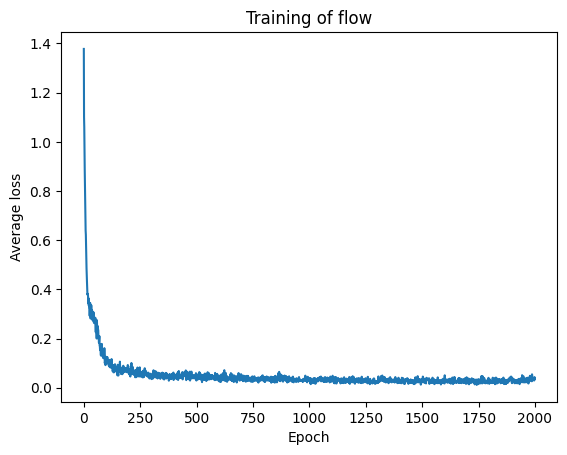

In [14]:
plt.plot(epoch_list, loss_list)
plt.title('Training of flow')
plt.xlabel("Epoch")
plt.ylabel("Average loss")
plt.show()

In [15]:

# ---- save state dicts
torch.save({
    'vf_state': vf_model.state_dict(),
    'cell_conditioner_state': cell_conditioner.state_dict(),
    'latent_dim': latent_dim,
    'num_cell_types': num_cell_types,
}, flow_model_save_path)
print("Saved model state to", flow_model_save_path)

Saved model state to /dtu/blackhole/06/213542/paperdata/simple_flow_model_state.pth


In [19]:
# ---- sampling with classifier-free guidance
def sample_with_cfg(vf_model, cell_conditioner, target_type_idx:int, 
                    lib_mean, lib_std, # ---- NEW: Accept stats
                    n_samples=1000, guidance_scale=2.0, n_steps=50, dt=1.0/50, device='cpu'):
    vf_model.eval()
    cell_conditioner.eval()
    latent_dim = latent_dim_global 

    x = torch.randn(n_samples, latent_dim, device=device)

    type_idx_tensor = torch.full((n_samples,), target_type_idx, dtype=torch.long, device=device)
    z_cond = cell_conditioner(type_idx_tensor)
    z_uncond = torch.zeros(n_samples, latent_dim, device=device)

    # ---- NEW: Sample Library Sizes from Normal distribution (Appendix C.4)
    # Since we use log-library sizes, we sample from Normal(mean, std)
    l_sample = torch.normal(mean=lib_mean.item(), std=lib_std.item(), size=(n_samples, 1), device=device)

    t = torch.zeros(n_samples, 1, device=device)
    
    for step in range(n_steps):
        # ---- NEW: Pass l_sample to both cond and uncond passes
        v_uncond = vf_model(x, z_uncond, t, l_sample)
        v_cond = vf_model(x, z_cond, t, l_sample)
        
        v_guided = v_uncond + guidance_scale * (v_cond - v_uncond)

        x = x + v_guided * dt
        t = t + dt

    return x

In [20]:
# convenience helper
latent_dim_global = latent_dim

# Example: generate 1000 samples conditioned on the first cell type
target_type_idx_example = 0

# ---- NEW: Pass lib_mean and lib_std
generated = sample_with_cfg(vf_model, cell_conditioner, target_type_idx_example, 
                            lib_mean=lib_mean, lib_std=lib_std,
                            n_samples=1000,
                            guidance_scale=guidance_scale, n_steps=n_steps, dt=dt, device=device)

print("Generated shape:", generated.shape)
torch.save(generated.cpu(), generated_save_path)
print("Saved generated latent to", generated_save_path)

Generated shape: torch.Size([1000, 50])
Saved generated latent to /dtu/blackhole/06/213542/paperdata/simple_generated_latent.pt
